<img src="../../img/hyperparameter_tuning.png" alt="Hyperparameter Tuning" style="width: 100%; border-radius: 20px;"/>

In [4]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../../')

import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

from utils.modeling import *

2024-03-19 15:47:19.797079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%%HTML
<style>
    body {
        --vscode-font-family: "Itim"
    }
</style>

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following files are required:
- ...

In [8]:
train_path = '../../../../01_Data/datasets/evaluation_data/master_train.csv'  # master dataset, 27 species, EEA grids
validata_path = '../../../../01_Data/datasets/evaluation_data/master_validata.csv'  # master validata, 27 species, EEA grids

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣ Load data </p>
For this notebook, we are using the standardized dataset containing bird sightings data from both Switzerland and Germany spanning from 2018 to 2022. It already contains our self-generated features `eea_grid_id`, `altitude`, and `land_use`.

Additionally, we apply the validation dataset provided by ornitho.ch for evaluation, comprising both correct and manually falsified data points from 2023.

In [9]:
X_train = pd.read_csv(train_path, index_col=0, low_memory=False)
X_test = pd.read_csv(validata_path, index_col=0, low_memory=False)
y_test = X_test['edited']
y_test_per_species = X_test[['name_species', 'edited']]
X_test = X_test.drop(columns=['edited'])

In [10]:
X_train.date = pd.to_datetime(X_train.date).dt.dayofyear
X_test.date = pd.to_datetime(X_test.date).dt.dayofyear

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Emergent Filter optimization </p>

##

In [11]:
path_to_lookup_table = '../../../../01_Data/models/emergent_filters_selected_species_grids_50km.pkl'
with open(path_to_lookup_table, 'rb') as f:
    emergent_filters = pickle.load(f)

In [13]:
conf_mats = []
thresholds = np.arange(0.01, 0.3, 0.01)
thresholds = [0.01, 0.025, 0.5]
for threshold in thresholds:
    conf_mat = evaluate_emergent_filters(X_test, y_test, emergent_filters, threshold=threshold)
    conf_mats.append(conf_mat)

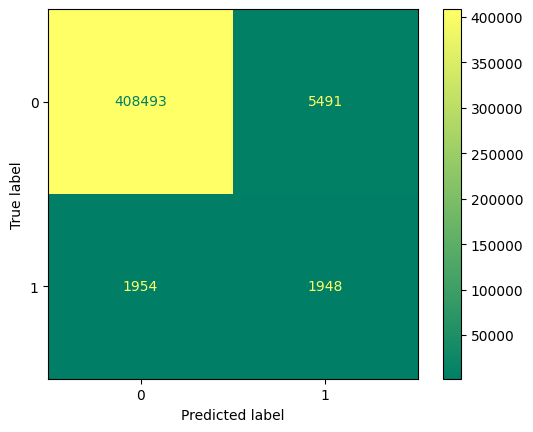

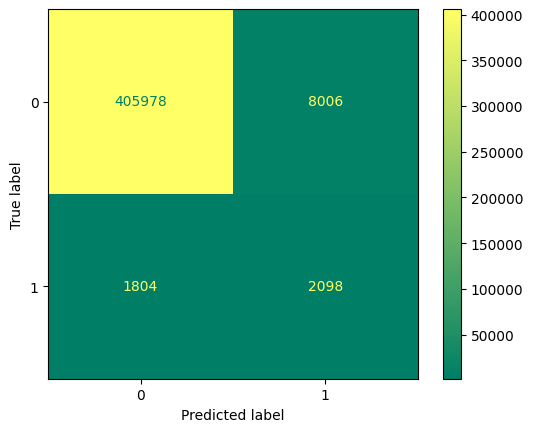

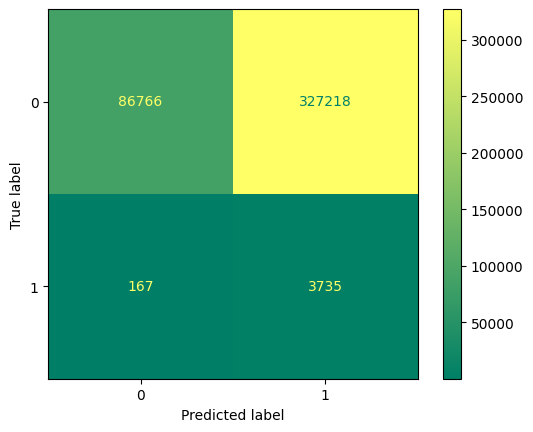

In [14]:
for conf_mat in conf_mats:
    ConfusionMatrixDisplay(conf_mat).plot(cmap='summer');

In [9]:
tp, tn, fp, fn = get_confusion_matrix_values(conf_mats)
plot_fn_vs_fp(fn, fp, thresholds, 'threshold')

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣ Outlier Detection optimization </p>

In [10]:
X_train_per_species = prepare_df_for_outlier_detection(X_train, features=['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count'])
X_test_per_species = prepare_df_for_outlier_detection(X_test, features=['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count'])

## DBSCAN

In [11]:
conf_mats_dbscan = []
for species in X_train_per_species.keys():
    conf_mat = evaluate_dbscan(X_train_per_species[species],
                               X_test_per_species[species],
                               y_test_per_species[y_test_per_species.name_species == species].edited)
    conf_mats_dbscan.append(conf_mat)

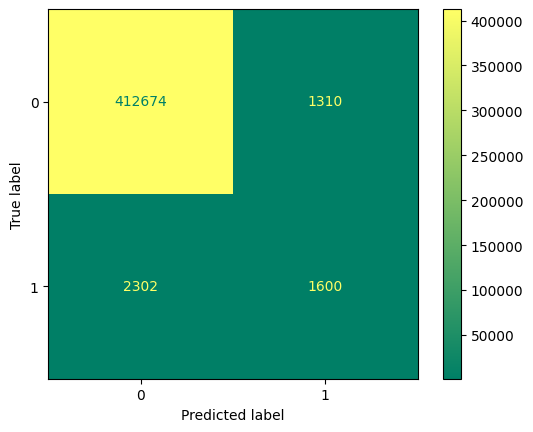

In [12]:
conf_dbscan = np.sum(conf_mats_dbscan, axis=0)
ConfusionMatrixDisplay(conf_dbscan).plot(cmap='summer');

## Isolation Forest

In [13]:
conf_mats_if = []
for species in X_train_per_species.keys():
    conf_mat = evaluate_isolation_forest(X_train_per_species[species], 
                                         X_test_per_species[species], 
                                         y_test_per_species[y_test_per_species.name_species == species].edited)
    conf_mats_if.append(conf_mat)

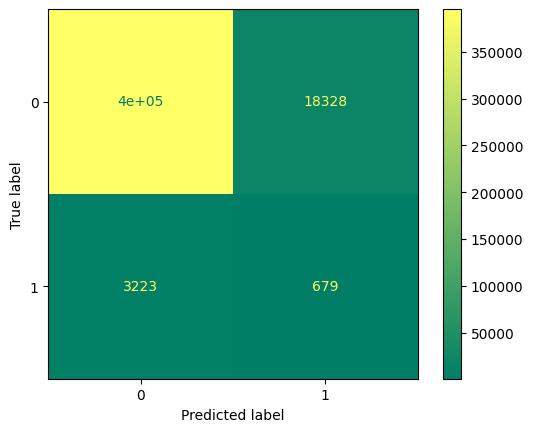

In [14]:
conf_if = np.sum(conf_mats_if, axis=0)
ConfusionMatrixDisplay(conf_if).plot(cmap='summer');

## AutoEncoder

In [ ]:
conf_mats_ae = []
for species in X_train_per_species.keys():
    conf_mat = evaluate_autoencoder(X_train_per_species[species],
                                    X_test_per_species[species],
                                    y_test_per_species[y_test_per_species.name_species == species].edited)
    conf_mats_ae.append(conf_mat)

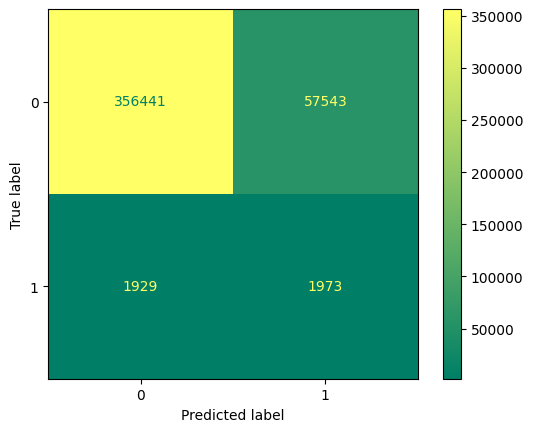

In [19]:
conf_ae = np.sum(conf_mats_ae, axis=0)
ConfusionMatrixDisplay(conf_ae).plot(cmap='summer');